<a href="https://colab.research.google.com/github/igorlysov/CP2022/blob/main/homeworks/interactive_fractal_map_Lysov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Интерактивная карта фрактального множества

### Условие задачи

**Дано:**

- [бассейн Ньютона](https://ru.wikipedia.org/wiki/Бассейны_Ньютона)
  
  $p(z) = z^3 - 1$


Обозначим за $\lambda$:
 - количество итераций (множество Жюлиа),
 - количество итераций для достижения заданной погрешности достижения корня (бассейны Ньютона)
 - экспонента Ляпунова (фрактал Ляпунова)

**Требуется**

 - реализовать функции и откомпилировать их при помощи модуля `Numba`:
     - расчет $\lambda$ для точки на комплексной плоскости
     - расчет $\lambda$ на регулярной решетке на комплексной плоскости (эта функция должна быть распараллелена при помощи `prange`)

 - создать интерактивную карту при помощи класса `DynamicMap` модуля `holoviews`:
     - цветом отобразить значение $\lambda$
     - выбрать цветовую карту [colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
     - размеры карты - не менее 600 х 600 точек
     - отрегулировать количество итераций так, чтобы время вычисления одного обновления карты было менее 1 секунды

 - сохранить 5 различных изображений:
     - найти красивые места на карте, применив переносы и масштабирования
     - воспользоваться кнопкой сохранения на интерактивной карте

 - добавить описание:
     - к каждой константе (комментарий)
     - к каждой функции (`docstring`)

**Правила оценивания:**

- оценка за корректно реализованные функции и созданную интерактивную карту `100` баллов

- штрафы $p(i)$, баллов:
    - не работает интерактивная карта - 50
    - ошибки в реализации функций - 20
    - не выполнена компиляция и распараллеливание - 20
    - отсутствует 5 изображений - 20
    - отсутствует `docstring` - 20
    - менее значимые недоработки - 10
    - другие ошибки штрафуются индивидуально в зависимости от их тяжести

- итоговая оценка за задание = $100 - \sum_{i}{p(i)}$



<center>
    <img src='https://drive.google.com/uc?id=19wJawCfodWP-2QyxYGO2bu0cSFPB_qL4' width="500"/>
</center>

In [ ]:
from timeit import timeit
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

In [ ]:
@njit(fastmath = True)
def newton_point(z, max_iterations=1000):
  '''
  Функция, вычисляющая количество итераций метода Ньютона до достижения критерия
  остановки для одной некоторой точки z

  z(n+1) = z(n) - p(z(n)) / dp(z(n))
  пока не |z(n+1) - z(n)| < accuracy 

  где p(z) = z^3 - 1  =>  dp(z) = dp/dz = 3z^2
  ------------------------------------------------------------------------------

  Аргументы: 
      z: точка на комплексной плоскости
      max_iterations: максимально возможное количество итераций
  ------------------------------------------------------------------------------

  Возвращаемое значение: 
      lambda_: количество итераций до достижения критерия остановки
  '''
  for lambda_ in range(max_iterations):
    z_prev = z
    z = z - (z*z*z - 1) / (3 * z*z)
    if abs(z - z_prev) < (1e-4):
      break
  return lambda_

@njit(parallel = True, fastmath = True)
def newton_plane(x_min, x_max, y_min, y_max, x_num, y_num, max_iterations=1000):
  '''
  Функция, вычисляющая количество итераций метода Ньютона до достижения критерия
  остановки для каждой точки регулярной решетки размера (x_num * y_num)
  ------------------------------------------------------------------------------
  
  Аргументы:
      x_min: минимально возможное значение координаты x
      x_max: максимально возможное значение координаты x
      y_min: минимально возможное значение координаты y
      y_max: максимально возможное значение координаты x
      x_num: количество точек на оси x 
      y_num: количество точек на оси x 
      max_iterations:максимально возможное количество итераций
  ------------------------------------------------------------------------------

  Возвращаемое значение: 
      grid_iterations: матрица количество итераций до достижения критерия 
      остановки для каждой точки (x, y) координатной сетки

  '''
  # размеры "пикселей"
  dx = (x_max - x_min) / x_num
  dy = (y_max - y_min) / y_num
  grid_iterations = np.empty((y_num + 1, x_num + 1), dtype=np.uint16)
  for iy in prange(y_num + 1):
    for ix in range(x_num + 1):
      # текущая точка
      x = x_min + dx * ix
      y = y_min + dy * iy
      # точка на комплексной плоскости
      z = x + 1j * y
      # количество итераций для точки z = (x, y)
      lambda_iterations = newton_point(z, max_iterations)
      grid_iterations[ix, iy] = lambda_iterations
  return grid_iterations

In [ ]:
x_num, y_num = 600, 600  # уменьшенная задача
x_num_full, y_num_full = 6000, 6000  # полная задача

In [ ]:
# диапазоны значений для x, y
x_min, x_max = -1.0, 1.0
y_min, y_max = -1.0, 1.0

In [ ]:
# замеры времени для сетки 600 х 600
%%time
res = newton_plane(x_min, x_max, y_min, y_max, x_num, y_num)

CPU times: user 127 ms, sys: 315 µs, total: 127 ms
Wall time: 69.5 ms


In [ ]:
# замеры времени для сетки 6000 х 6000
%%time
res_full = newton_plane(x_min, x_max, y_min, y_max, x_num_full, y_num_full)

CPU times: user 11.3 s, sys: 6.98 ms, total: 11.3 s
Wall time: 5.81 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


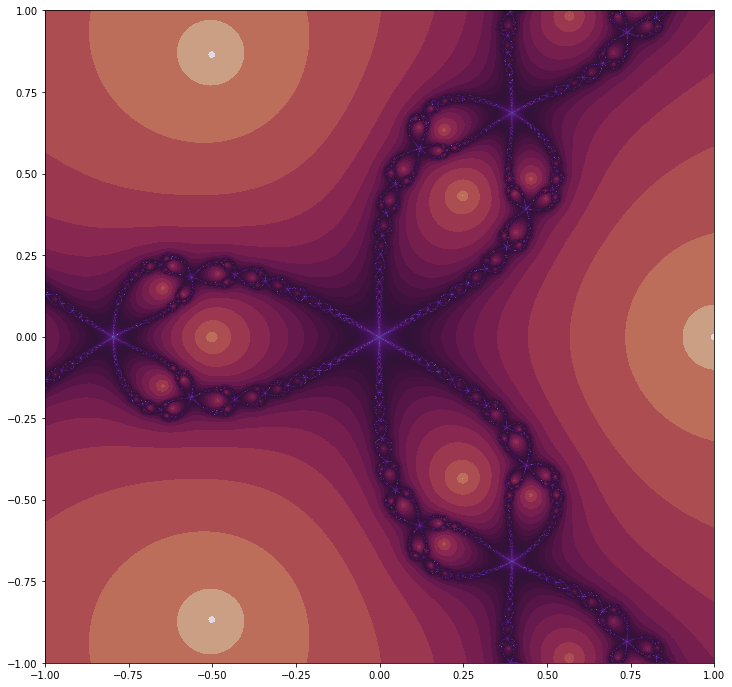

In [ ]:
r = 6.0
step = 1
plt.figure(figsize=((x_max - x_min)*r, (y_max - y_min)*r))
x = np.linspace(x_min, x_max, x_num_full + 1)
y = np.linspace(y_min, y_max, y_num_full + 1)

plt.pcolormesh(x[::step], y[::step], np.log(res_full[::step, ::step]), 
               cmap='twilight_r',
               shading='auto')

In [ ]:
# параметры прямоугольной области выделения части изображения
width, height = 300, 300
xstart, ystart = 4000, 670
xstop, ystop = xstart + width, ystart + height

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


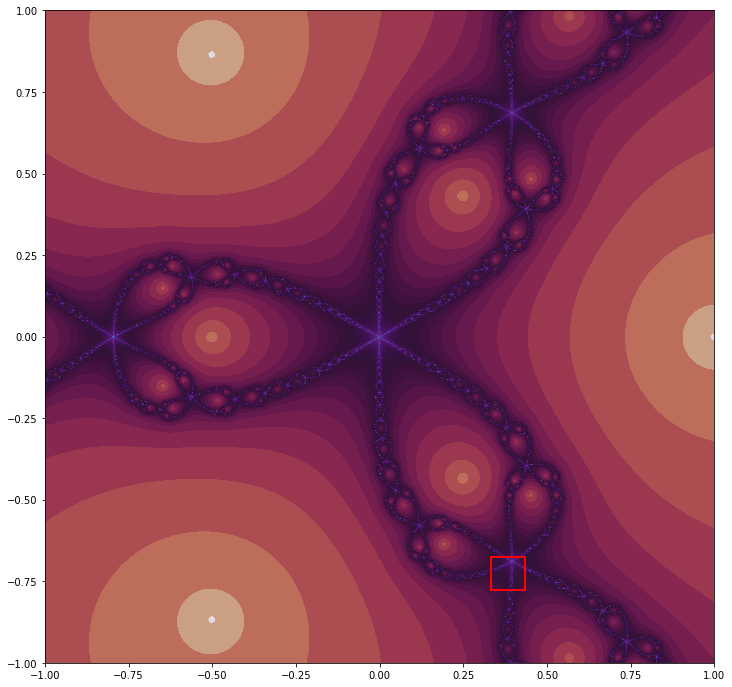

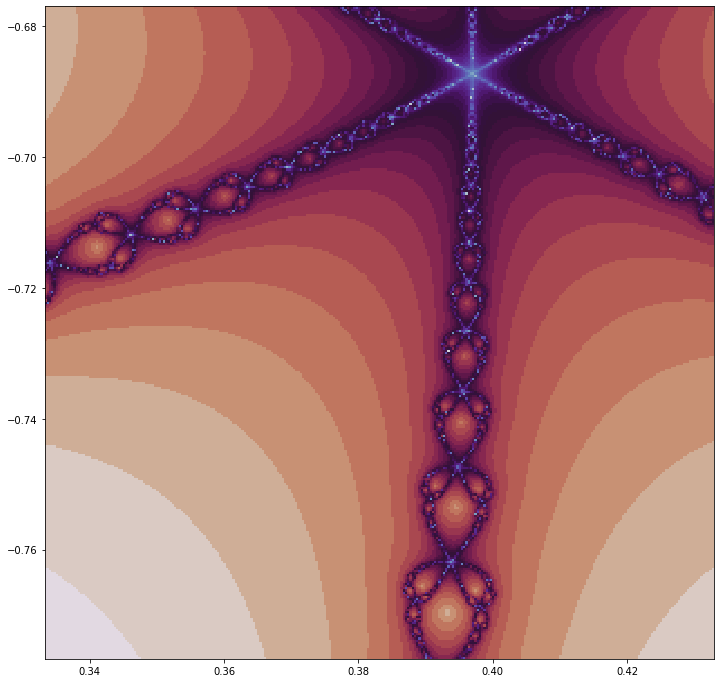

In [ ]:
r = 6.0
step = 1
plt.figure(figsize=((x_max - x_min)*r, (y_max - y_min)*r))
x = np.linspace(x_min, x_max, x_num_full + 1)
y = np.linspace(y_min, y_max, y_num_full + 1)

plt.pcolormesh(x[::step], y[::step], np.log(res_full[::step, ::step]), 
               cmap='twilight_r',
               shading='auto')

rect = plt.Rectangle([x[xstart], y[ystart]], \
                     x[xstop] - x[xstart], 
                     y[ystop] - y[ystart],
                     fill = False, color='red', lw=2)
plt.gca().add_artist(rect)

# зумированная область

plt.figure(figsize=((x_max - x_min)*r, (y_max - y_min)*r))
x = np.linspace(x_min, x_max, x_num_full + 1)
y = np.linspace(y_min, y_max, y_num_full + 1)

plt.pcolormesh(x[xstart:xstop], 
               y[ystart:ystop], 
               np.log(res_full[ystart:ystop, xstart:xstop]), 
               cmap='twilight_r',
               shading='auto')

In [ ]:
%env HV_DOC_HTML=true

env: HV_DOC_HTML=true


In [ ]:
import holoviews as hv
from holoviews import opts
from holoviews.streams import RangeXY

In [ ]:
# размеры картинки
image_width, image_height = 600, 600
# максимальное количество итераций для динамической карты
max_it = 200

# диапазоны значений для (x, y)
x_min, x_max = -1.0, 1.0
y_min, y_max = -1.0, 1.0

In [ ]:
def get_fractal(x_range, y_range):
  '''
  Сallback-функция, динамичесик обновляющая карту
  ------------------------------------------------------------------------------

  Аргументы:
      x_range: (x_min, x_max) пара
      y_range: (y_min, y_max) пара
  ------------------------------------------------------------------------------

  Возвращаемое значение:
      img: изображение фрактала Ньютона
  '''
  x0, x1 = x_range
  y0, y1 = y_range
  arr = newton_plane(x0, x1, y0, y1, image_width, image_height, max_it)
  img = hv.Image(arr, bounds=(x0, y0, x1, y1))
  return img

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
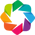

:DynamicMap   []
   :Image   [x,y]   (z)

In [ ]:
hv.extension('bokeh')

# поток, связанных с диапазонами осей X и Y 
range_stream = RangeXY(x_range=(x_min, x_max), 
                       y_range=(y_min, y_max))

# динамическая карта, рассчитывающая фрактал 
dmap = hv.DynamicMap(get_fractal, streams=[range_stream])

# настройки:
# размеры рисунка 600x600
# брать логарифм от значений функции

dmap.opts(opts.Image(cmap='twilight_r', logz=True, 
                     height=image_height, width=image_width))

Теперь посмотрим на отобранные места, сохраненные с помощью кнопки на динамической карте

In [ ]:
# cкачивание набора фотографий с диска 
!gdown https://drive.google.com/uc?id=1bfefhu-zK1V6vvqbppPI5KHtIHoIFfQ3
!gdown https://drive.google.com/uc?id=1oisxUMqUZT_9GHZ1I01NWBUYBrWlyC5G
!gdown https://drive.google.com/uc?id=17xemkLm93KuIadQI6dLn3Ps46AsXZ9Ea
!gdown https://drive.google.com/uc?id=1NSHPoqXVW9dN82rIOFTTxED4CgOs9arG
!gdown https://drive.google.com/uc?id=1j_LTplxtb5vjwy8m7IQGJ043BVN9hFdd

Downloading...
From: https://drive.google.com/uc?id=1bfefhu-zK1V6vvqbppPI5KHtIHoIFfQ3
To: /content/bokeh_plot (8).png
100% 54.6k/54.6k [00:00<00:00, 66.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oisxUMqUZT_9GHZ1I01NWBUYBrWlyC5G
To: /content/bokeh_plot (7).png
100% 60.0k/60.0k [00:00<00:00, 68.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=17xemkLm93KuIadQI6dLn3Ps46AsXZ9Ea
To: /content/bokeh_plot (6).png
100% 46.0k/46.0k [00:00<00:00, 63.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NSHPoqXVW9dN82rIOFTTxED4CgOs9arG
To: /content/bokeh_plot (5).png
100% 46.7k/46.7k [00:00<00:00, 61.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j_LTplxtb5vjwy8m7IQGJ043BVN9hFdd
To: /content/bokeh_plot (3).png
100% 54.2k/54.2k [00:00<00:00, 61.0MB/s]


In [ ]:
from PIL import Image

In [ ]:
fractal_images = []
for i in [3, 5, 6, 7, 8]:
  image_file = f"//content//bokeh_plot ({i}).png"
  fractal_images.append(Image.open(image_file))

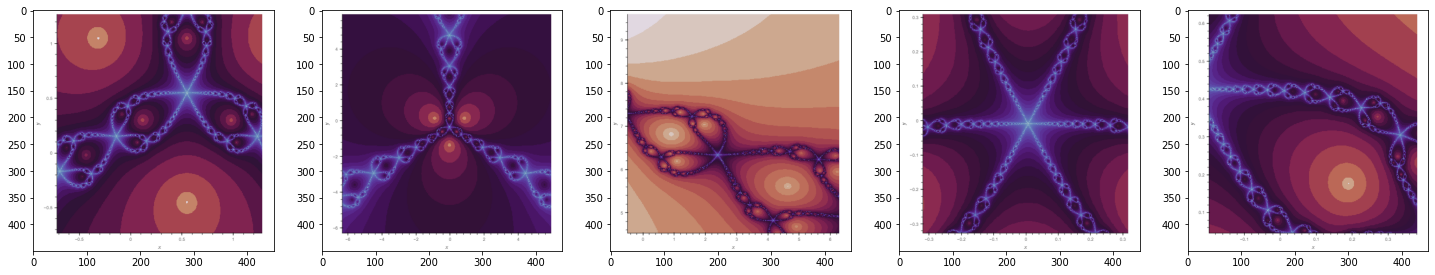

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(25,15))

for i in range(len(fractal_images)):
  ax[i].imshow(fractal_images[i])